# Notebook for calculating APWP from the VGP compilation and using the method of Gallo et al., 2023 to propagate uncertainty through the path

## import Python libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs

from vgptools.utils import (spherical2cartesian, cartesian2spherical, 
                               shape, PD, eigen_decomposition,
                               GCD_cartesian, get_angle)
from vgptools.utils_visualization import plot_pole_A95, plot_pole
from vgptools.utils_classes import PC, quantiles

%matplotlib inline

## import compilation data

In [2]:
Keweenawan_track_site_data = pd.read_csv('../data/pmag_compiled/Keweenawan_track_sites.csv')
Keweenawan_track_site_data.head()

,pole_name,age,age_high,age_low,age_unit,age_uncertainty,citations,dir_alpha95,dir_polarity,dir_dec,...,dir_n_samples,dir_tilt_correction,dir_r,vgp_lat_rev,vgp_lon_rev,vgp_dm,vgp_dp,paleolatitude,Plon,Plat
0,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,2.7,r,79.7,...,NaN,NaN,NaN,33.098356,229.588330,NaN,NaN,-54.692457,229.588330,33.098356
1,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.4,r,74.1,...,NaN,NaN,NaN,30.447349,231.831739,NaN,NaN,-54.393410,231.831739,30.447349
2,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,6.8,r,87.5,...,NaN,NaN,NaN,35.321456,223.912252,NaN,NaN,-52.341346,223.912252,35.321456
3,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,4.9,r,75.7,...,NaN,NaN,NaN,29.952660,229.585495,NaN,NaN,-52.630096,229.585495,29.952660
4,Osler reverse lower,1108.0,1110.0,1105.15,Ma,uniform,Swanson-Hysell et al. 2014,3.9,r,109.8,...,NaN,NaN,NaN,45.769076,210.954452,NaN,NaN,-49.396782,210.954452,45.769076


In [5]:
Keweenawan_track_study_data = pd.read_csv('../data/pmag_compiled/keweenawan_pole_means.csv')
Keweenawan_track_study_data.head()

,Polarity,PoleName,SLat,SLon,PLat,PLon,A95,K,N,PolarityZone,PmagRef,AgeNominal,AgeLower,AgeUpper,AgeInfo,AgeRef,Gaussian_2sigma,GaussianOrUniform,Q,color
0,Osler_R1,Osler reverse (lower),48.80,272.34,40.9,218.6,4.8,31.5,30,Alona Bay reversed-polarity zone,"Swanson-Hysell et al., 2014b",1108.00,1105.15,1110.00,Older than 1105.15 $\pm$ 0.33 Ma Osler_R2 pole...,"Davis and Sutcliffe, 1985; this study",NaN,uniform,7.0,#B82431
1,Osler_R2,Osler reverse (upper),48.59,271.81,42.3,203.4,3.7,24.4,64,Alona Bay reversed-polarity zone,"Halls, 1974; Swanson-Hysell et al., 2014b; thi...",1105.15,1104.82,1105.48,$^{\mathrm{206}}$Pb/$^{\mathrm{238}}$U date of...,this study,0.33,gaussian,7.0,#F2A07E
2,MP_lowerR1,Mamainse lower reversed 1,47.10,275.29,49.5,227.0,5.3,31.7,24,Alona Bay reversed-polarity zone,"Swanson-Hysell, 2014a",1109.00,1106.00,1112.00,Likely older than ca. 1105 Ma given distinct h...,NaN,NaN,uniform,7.0,#930E26
3,MP_lowerR2,Mamainse lower reversed 2,47.09,275.27,37.5,205.2,4.5,78.6,14,Alona Bay reversed-polarity zone,"Swanson-Hysell, 2014a",1105.00,1100.40,1109.00,Older than $^{\mathrm{206}}$Pb/$^{\mathrm{238}...,"Swanson-Hysell, 2014a",NaN,uniform,7.0,#F8C1A6
4,MP_lowerNupperR,Mamainse lower normal and upper reversed,47.07,275.26,36.1,189.7,4.9,37.3,24,Flour Bay normal and reversed polarity zones,"Swanson-Hysell, 2014a",1100.36,1100.10,1100.61,Age constrained by $^{\mathrm{206}}$Pb/$^{\mat...,"Swanson-Hysell, 2014a",0.25,gaussian,7.0,#6A579A


## Running mean APWP

One of the most commonly used method of synthesizing APWP is to do a running mean calculation with a user-defined window size over study-level paleomagnetic poles. This approach has the simplicity of calculating parametric Fisher means of study-level poles. However it has many disadvantages. It does not propagate uncertainties of site-level data into running mean poles. It has the assumption that the running mean study-level poles are Fisher distributed. It takes mean of study-level poles which could bias the mean poles into regions of high study-level pole density. It did not take into account ages and age uncertainties of study-level poles. 

We will show the running mean Keweenawan Track here as was done in Swanson-Hysell et al., 2019.

In [24]:
def running_mean_APWP(data, window_length,spacing,max_age,min_age):
    mean_pole_ages = np.arange(min_age,max_age+spacing,spacing)
    running_means = pd.DataFrame(columns=['age','N','A95','PLon','PLat'])

    for age in mean_pole_ages:
        window_min = age - (window_length/2)
        window_max = age + (window_length/2)
        poles = data.loc[(data['AgeNominal'] >= window_min) & (data['AgeNominal'] <= window_max)]
        mean = ipmag.fisher_mean(dec=poles['PLon'].tolist(),inc=poles['PLat'].tolist())
        running_means.loc[age] = [age,mean['n'],mean['alpha95'],mean['dec'],mean['inc']]
        
    m = ipmag.make_orthographic_map(200, 20, figsize=(6,6))
    # for n in range(0,len(running_means['PLon'].tolist())):
    ipmag.plot_poles_colorbar(m,running_means['PLon'].tolist(),
                                running_means['PLat'].tolist(),
                                running_means['A95'].tolist(), 
                                colorvalues=running_means['age'].tolist(),
                                vmin=min_age,
                                vmax=max_age,
                                colormap='viridis_r', edgecolor='none', 
                                marker='o', markersize=50)
    
    return m, running_means

### running mean with 20 Myr window size and 10 Myr spacing between 1110 and 1070 Ma

(<GeoAxesSubplot:>,
          age     N        A95        PLon       PLat
 1070  1070.0   2.0  14.537401  179.397454   6.300152
 1080  1080.0   5.0  10.382494  180.244070  16.062528
 1090  1090.0   8.0   6.461766  181.121849  25.533662
 1100  1100.0  12.0   7.796519  196.481069  38.734528
 1110  1110.0   7.0   7.655953  207.947114  43.150002)

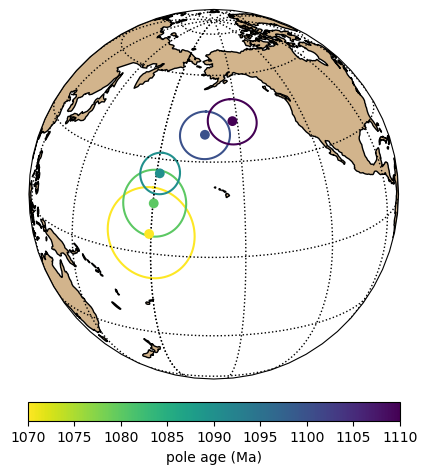

In [25]:
RM_20_10_1110_1070 = running_mean_APWP(Keweenawan_track_study_data,20,10,1110,1070)
RM_20_10_1110_1070

### running mean with 20 Myr window size and 10 Myr spacing between 1115 and 1075 Ma

(<GeoAxesSubplot:>,
          age    N        A95        PLon       PLat
 1075  1075.0  3.0  11.453527  177.870358   9.873297
 1085  1085.0  7.0   6.613401  181.351803  23.902109
 1095  1095.0  8.0   6.025632  186.002400  31.579997
 1105  1105.0  9.0   8.725792  201.267822  41.708913
 1115  1115.0  6.0   6.847605  211.337685  44.015279)

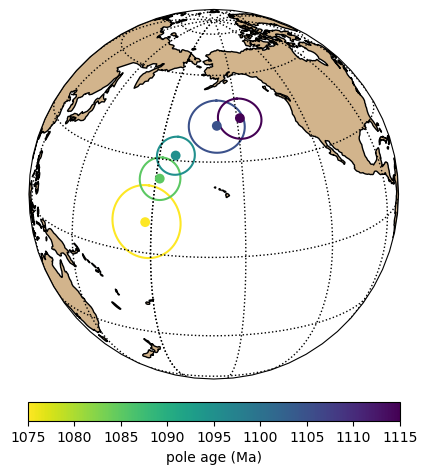

In [26]:
#RM_20_10_1115_1075 = running_mean_APWP(pole_means,20,10,1115,1075,fig_name='running_mean')
RM_20_10_1115_1075 = running_mean_APWP(Keweenawan_track_study_data,20,10,1115,1075)
RM_20_10_1115_1075

In [ ]:
# We could drop the two poles with less than 10 VGPs
# pole_means_filtered = pole_means.drop('Osler_N')
# pole_means_filtered = pole_means_filtered.drop('QM')

## Bootstrap VGP based + MC age based APWP implementing Gallo et al., 2023 method

## 2. The following function generates a bootstrap sample $X_b$ from the original dataset $X$. Then, it uses Monte Carlo resampling to generate for each site-level sample $X_{bi}$:

This uncertainty propagation algorithm has the following steps:

1. Generate a bootstrap site-level compilation from the original dataset. 

2. In the bootstrap site-level compilation, for each site-level sample, generate a Monte Carlo sample of directions (dec, inc) assuming Fisher distributed uncertainty using the directional kappa parameter. 

3. 


- a direction $\hat \mu_{bi}$ from the probability distribution $\text{Fisher}(\mu_i, \kappa_i)$
- an age $\hat t_{bi}$ from $N(t_i, \sigma_i)$ or $U(t_{max}, t_{max})$ (depending on whether $i$ is radiometrically or stratigraphically constrained, respectively)
- For each $X_{bi}$, calculate and store $VGP_{bi}$ and associated age $\hat t$.

In [ ]:
def get_vgps_sampling_from_direction(df, study_label= 'Study',
                                     slat_label='slat', slon_label='slon', 
                                     dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                                     mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age'):
    
    '''
    Input:
    
    DF with the following site-level information: 
    - Study, site coordinates, mean direction, concentration parameter, mean age and error distribution. 
    
    Steps:
    1. generate a pseudo-sample from the original dataset using nonparametric random sampling 
    with replacement (bootstrap sample).
    2. For each row (site-level entry) in the bootstrap sample draws a random direction following 
    the kappa concentration parameter and mean direction. Note here our assumption is that site-level uncertainties 
    are associated with random errors generated during field sample collection and lab sample handling and during 
    experiements such that they can be treated as Fisher distributed around the mean directions. Note that this 
    assumed error circle in directional space would not map to a circularly symmetric error ellipse in pole space.
    3. Assign an age to the resampled directional data from the corresponding age assignments 
    and associated type of uncertainty (uniform or gaussian).
    3. For each row, calculates the corresponding VGP. 
    
    Note: input directions must be all in the same mode (sensu PmagPy) so that we get coherent vgps. 
    Given that we are used to looking at the Keweenawan Track in the northern hemisphere, we will work with normal inclinations   
    
    Output:
    
    - A DataFrame with the same size than the original dataset, with randomized parameters.  
    '''    
    Study, age_bst, decs, incs, slat, slon, indexes = [], [], [], [], [], [], [] # parameters of the pseudo-sample to be filled
    
    k_mean = df[k_label].mean() # if site-level data has no reported kappa, we take the mean of the population instead.
    
    # df_pseudo = df.sample(frac = 1, replace = True) # generates a bootstrapped sample of the dataframe by randomly sampling with replacement
    
    for index, row in df.iterrows():        
        
        # we first generate one random direction from the original entry.
        kappa = k_mean if np.isnan(row[k_label]) else row[k_label] # if we don't have kappa, we take the mean of the reported ones       
        n = 3 if np.isnan(row.n) else int(row.n)
        
        # directions_temp = ipmag.fishrot(k = kappa, n = 1, dec = row[dec_label], inc = row[inc_label], di_block = False)
        directions_temp = ipmag.fishrot(k = kappa, n = n, dec = row[dec_label], inc = row[inc_label], di_block = False)        
        site_mean = ipmag.fisher_mean(dec = directions_temp[0], inc = directions_temp[1])        
        
        decs.append(site_mean['dec'])
        incs.append(site_mean['inc'])        
        # decs.append(directions_temp[0][0])
        # incs.append(directions_temp[1][0])
        slat.append(row[slat_label])
        slon.append(row[slon_label])
        indexes.append(index)
        Study.append(row[study_label])
        
        # Assessing the uncertianty distribution (uniform or normal)
        if row.uncer_dist == 'uniform':
            age_bst.append(np.random.randint(np.floor(row[min_age_lab]),np.ceil(row[max_age_lab])))
        else:            
            age_bst.append(np.random.normal(row[mean_age_lab], (row[max_age_lab] - row[mean_age_lab]) / 2)) 
            # the files were completed in such a way to have min and max ages, so we take sigma as a half of that range
    
    dictionary = {
                  'Study': Study,
                  'age': age_bst,
                  'dec': decs,    
                  'inc': incs,
                  'slat': slat,
                  'slon': slon 
                  }    
    new_df = pd.DataFrame(dictionary)        
       
    #new_df['plon'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    new_df['plon'] = pmag.dia_vgp(new_df['dec'], new_df['inc'], 1, new_df['slat'], new_df['slon'])[0]
    
    #new_df['plat'] = new_df.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    new_df['plat'] = pmag.dia_vgp(new_df['dec'], new_df['inc'], 1, new_df['slat'], new_df['slon'])[1]
    
    # set longitude in [-180,180]
    #new_df['plon'] = new_df.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)
    new_df['plon'] = new_df['plon'].where(new_df['plon'] <= 180, new_df['plon'] - 360)

    new_df.index = indexes

    return new_df

2. The following function performs a weighted Moving average and gets its descriptive parameters:

In [ ]:
def weighted_moving_average_APWP(data, plon_label = 'plon', plat_label='plat', age_label = 'age',window_length=20, time_step=1, max_age=65, min_age=0):
    """
    Returns a data frame with a running mean (Moving average) APWP..
    
    Parameters: 
    - Data Frame with the folowing columns that need to be set [['vgp_lat'],['vgp_lon'],['age']]
    - time-step of the moving average (in Ma)
    - window size of the moving average (in Ma)
    
    * it also calculates descriptive parameters for the underlying distribution of VGPs within each window, e.g. : 
    - Number of VGPs,
    - Angular dispersion
    - Concentration
    - Shape (expressed as foliation, lineation, coplanarity and collinearity)
     
    * the APWP can also be described with some parameters, e.g.:
    - Apparent Polar wander rate (in degrees per Ma) between each time interval

    """
    
    mean_pole_ages = np.arange(min_age, max_age + time_step, time_step)
    
    running_means = pd.DataFrame(columns=['age','N','n_studies','k','A95','csd','plon','plat', 'foliation','lineation','collinearity','coplanarity','elong_dir',
                                         'effective_age','effective_age_std','effective_age_median','distance2age'])
    
    for age in mean_pole_ages:
        window_min = age - (window_length / 2.)
        window_max = age + (window_length / 2.)
        poles_ = data.loc[(data[age_label] >= window_min) & (data[age_label] <= window_max)]
        
        # weights = [(1-0.1)*(1-(np.abs( row.age - age ) / ((max_age - min_age) / 2)))+0.1 for i, row in poles.iterrows()]
        weights = [(1-(np.abs( row.age - age ) / ((window_max - window_min) / 2))) for i, row in poles_.iterrows()]
        poles = poles_.sample(n = len(poles_), weights = weights, replace = True)
        
        if poles.empty: continue
        
        number_studies = len(poles['Study'].unique())
        mean = ipmag.fisher_mean(dec=poles[plon_label].tolist(), inc=poles[plat_label].tolist())
        
        effective_age_mean = np.round(poles[age_label].to_numpy().mean()) #
        effective_age_sd = poles[age_label].to_numpy().std()
        distance2age = np.round(np.random.normal(effective_age_mean, effective_age_sd) - age)
        
        effective_age_median = np.round(np.median(poles[age_label].to_numpy()))
        
        ArrayXYZ = np.array([spherical2cartesian([np.radians(i[plat_label]), np.radians(i[plon_label])]) for _,i in poles.iterrows()])        
        if len(ArrayXYZ) > 3:
            shapes = shape(ArrayXYZ)
            PrinComp=PD(ArrayXYZ)
            eVal, eVec = eigen_decomposition(ArrayXYZ)
            elong_dir = np.degrees(cartesian2spherical(eVec[:,1]))[1] # from T&K2004 (declination od the intermediate Evec)
            # mean['inc']=np.degrees(cartesian2spherical(PrinComp))[0]
            # mean['dec']=np.degrees(cartesian2spherical(PrinComp))[1]
        else:
            shapes = [np.nan,np.nan,np.nan,np.nan]
        
        if len(poles)>2: #ensures that dict isn't empty
            running_means.loc[age] = [age, mean['n'], number_studies, mean['k'],mean['alpha95'], mean['csd'], mean['dec'], mean['inc'], 
                                      shapes[0], shapes[1], shapes[2], shapes[3], elong_dir,
                                     effective_age_mean, effective_age_sd, effective_age_median, distance2age]
    # Set longitudes in [-180, 180]
    running_means['plon'] = running_means.apply(lambda row: row.plon - 360 if row.plon > 180 else row.plon, axis =1)   
    
    # The following block calculates rate of polar wander (degrees per million years) 
    running_means['PPcartesian'] = running_means.apply(lambda row: spherical2cartesian([np.radians(row['plat']),np.radians(row['plon'])]), axis = 1)
    running_means['PP_prev'] = running_means['PPcartesian'].shift(periods = 1)
    running_means['PP_next'] =  running_means['PPcartesian'].shift(periods = -1)
    running_means['GCD'] = running_means.apply(lambda row: np.degrees(GCD_cartesian(row['PP_prev'], row['PPcartesian'])), axis = 1)
    running_means['APW_rate'] = running_means['GCD']/running_means['age'].diff()

    running_means['APW_rate_eff_age'] = running_means['GCD']/running_means['effective_age'].diff().replace(0, np.nan, inplace=False)
    
    # Calculate a 'kink' angle for each position of the path
    running_means['angle'] = running_means.apply(lambda row: get_angle(row['PP_prev'], row['PPcartesian'], row['PP_next']), axis = 1)

    running_means = running_means.drop(['PPcartesian', 'PP_prev', 'PP_next'], axis=1)      
    running_means.reset_index(drop=1, inplace=True)
    
    #set the present day field for the present
    running_means['plat'] = np.where(running_means['age']==0, -90, running_means['plat'])
    running_means['plon'] = np.where(running_means['age']==0, 0, running_means['plon'])
    
    return running_means


3. The following function performs the previous procedure a number of times a stores for each run the Moving Average along with their descriptive parameters

In [ ]:
def ensemble_RMs(df_vgps_original, n_sims = 100, 
                 study_label= 'Study', slat_label='slat', slon_label='slon', 
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=20, time_step=1, max_age=65, min_age=0):
    
    '''
    This function gets the pooled directions and return the ensemble Moving Averages following the workflow of Gallo et al. (2023) 
    '''
    
    running_means_global = pd.DataFrame(columns=['run','N','k','A95','csd','foliation','lineation','collinearity','coplanarity'])
    
    for i in range(n_sims):
    
        # Generate a pseudo-sample of the original dataset in which every entry is a pseudo-sample taken for the error PDF
        pseudo_df = get_vgps_sampling_from_direction(df_vgps_original, study_label= study_label,
                                             slat_label=slat_label, slon_label=slon_label, 
                                             dec_label=dec_label, inc_label=inc_label, k_label=k_label,
                                             mean_age_lab=mean_age_lab, min_age_lab=min_age_lab, max_age_lab=max_age_lab)

        # Construct a Moving Average on the former data-set
        RM = weighted_moving_average_APWP(pseudo_df, plon_label = 'plon', plat_label='plat', age_label = 'age', 
                            window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)
 
        RM['run'] = float(i)
        running_means_global = running_means_global.append(RM, ignore_index=True)

    running_means_global['plon'] = running_means_global['plon'].where(running_means_global['plon'] <= 180, running_means_global['plon'] - 360)
    return running_means_global

# Run an ensemble of Moving Avergaes:

First, we set the parameters of the moving average

In [ ]:
# Set the parameters for the Moving average
window_length= 21
time_step= 1 
max_age= 60
min_age= 0

## 4. We now proceed to run the workflow a great number of times in order to to get the ensemble statistics.

In [ ]:
%%time
np.random.seed(10)
df_RM_ensemble = ensemble_RMs(df_directions, n_sims = 500,
                 study_label= 'Study', slat_label='slat', slon_label='slon',
                 dec_label='dec_reverse', inc_label='inc_reverse', k_label='k',
                 mean_age_lab='mean_age', min_age_lab='min_age', max_age_lab='max_age',
                 plon_label = 'plon', plat_label='plat', age_label = 'age',
                 window_length=window_length, time_step=time_step, max_age=max_age, min_age=min_age)

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations